# Customer Churn Rate for E-commerce Company

<img src="images/CustomerService.gif" width="750" align="center">

## Business Problem

When we lose customers, we lose money. I have been tasked by the company heads to predict which customers are at risk of leaving (churning) and taking their business elsewhere. 

Taking into account a range of features, like membership status and website usage, I use machine learning models to successfully predict which customers the company should re-target to retain business.

## Overview

The data comes from the "Customer Churn" dataset, posted by Pawan Trivedi on Kaggle. I tried Decision Trees, Logistic Regression, K Nearest Neighbors, Random Forest, and finally XGBoost Classifier to find the best model for prediction. XGBoost Classifier was the best of the lot, succesfully predicting a little over 94% of targets in the test data. From there, I used the model to indicate the most important features, which were membership_category, village region, and customer care feedback.

Based on all of this, I recommend the company uses XGBoost Classifier moving forward to predict customer churn risk. I also suggest use membership category, village region, and customer care feedback to re-target customers.


## Data Understanding

The dataset contains columns focusing on customer site usage, customer transactions, customer demographics like age, gender, location, preferred device and internet type, and more.

In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# setting up the model
from sklearn import set_config
set_config(display= 'diagram')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

# scores
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, plot_roc_curve

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("data/churn.csv")
df.head(10)

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1
5,5,13,M,PSG1LGF,City,Gold Membership,2016-01-08,No,xxxxxxxx,Gift Vouchers/Coupons,...,433.62,13884.77,24.0,722.27,Yes,No,Yes,Unsolved,No reason specified,0
6,6,21,M,R3CX1EA,Town,Gold Membership,2015-03-19,Yes,CID24708,Gift Vouchers/Coupons,...,55.38,8982.50,28.0,756.21,Yes,No,Yes,Solved in Follow-up,No reason specified,0
7,7,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,...,429.11,44554.82,24.0,568.08,No,Yes,Yes,Unsolved,Poor Product Quality,1
8,8,44,M,0481QNQ,Village,Silver Membership,2016-12-14,No,xxxxxxxx,Without Offers,...,191.07,18362.31,20.0,NaN,Yes,No,Yes,Solved in Follow-up,Poor Customer Service,0
9,9,45,F,ZHP4MCR,Town,No Membership,2016-11-30,No,xxxxxxxx,Gift Vouchers/Coupons,...,97.31,19244.16,28.0,706.23,No,Yes,Yes,No Information Available,Poor Customer Service,1


This dataset has nearly 37,000 rows of data. What does the breakdown of our target, churn_risk_score, look like?

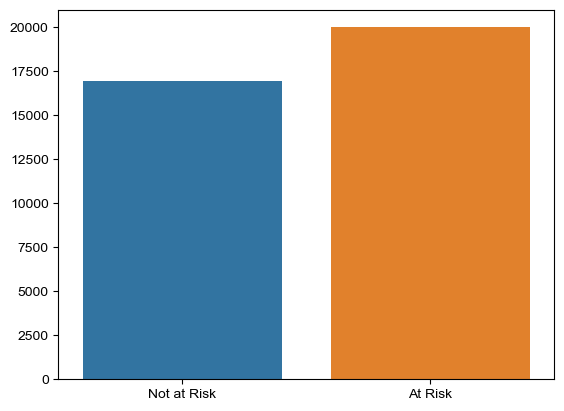

In [3]:
class_0 = (df["churn_risk_score"] == 0).sum()
class_1 = (df["churn_risk_score"] == 1).sum()

sns.barplot(x=["Not at Risk", "At Risk"], y=[class_0, class_1])
sns.set_style("darkgrid")
plt.show()

Our customer set is almost evenly split between at risk of churn (class 1) and not at risk of churn (class 0), though more customers are at risk of churn than not. 

We are in danger of losing over half our business if these customers leave. We need to figure out how we can predict churn risk for customers so we can re-target them with marketing and retain their business.

Intuitively, the best determinants of whether a customer will stay or leave would be their membership_category, avg_time_spent, or avg_transaction_value. Customers in high membership categories would likely stay with the company. Those who spend the most time on the site, log in frequently, or spend a lot of money might also be inclined to stay with the site.

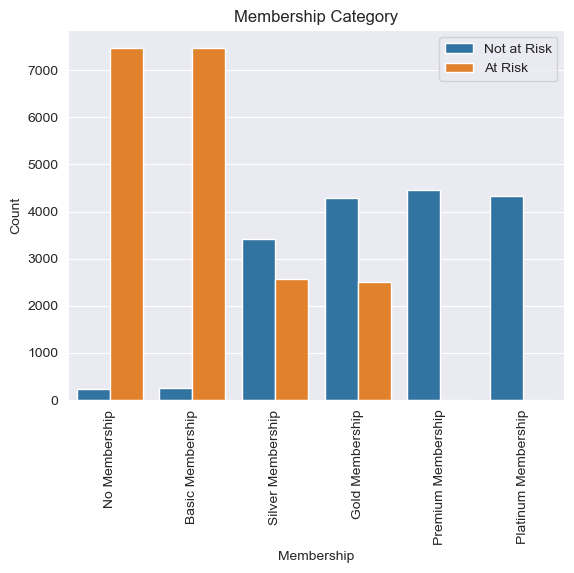

In [4]:
membership_order = ["No Membership", "Basic Membership", "Silver Membership", "Gold Membership", "Premium Membership",
                   "Platinum Membership"]
scores = df.copy()
scores["churn_risk_score"] = scores["churn_risk_score"].replace(0, "Not at Risk").replace(1, "At Risk")

sns.countplot(data=scores, x="membership_category", hue="churn_risk_score", order = membership_order)
plt.legend(loc='upper right')
plt.xticks(rotation = 90)
plt.title("Membership Category")
plt.xlabel("Membership")
plt.ylabel("Count");

Most customers seem to not be members or only hold basic membership. These seem to be the most at risk of churn, while premium and platinum memberships have no churn risk at all.

Already we can pinpoint some of the ways this company can hone in on who to re-target. Perhaps offering discounts on memberships or offering freebies to those who sign up could boost customer retention. 

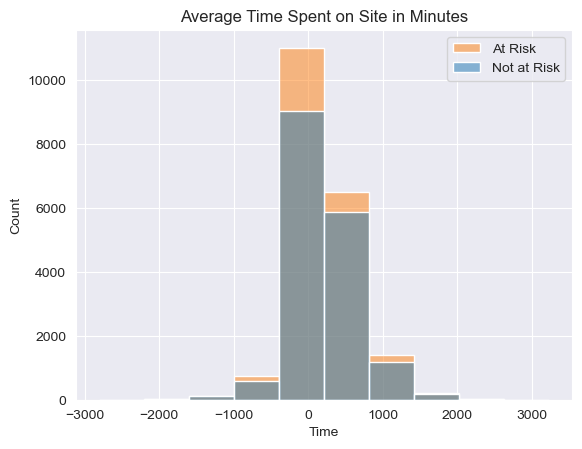

In [5]:
sns.histplot(data = scores, x = "avg_time_spent", hue="churn_risk_score", bins = 10)
plt.legend(loc='upper right', labels=['At Risk', 'Not at Risk'])
plt.title("Average Time Spent on Site in Minutes")
plt.xlabel("Time");

Avg_time_spent, while skewed heavily toward 0, doesn't seem to be a strong indicator of whether someone will churn or not. 

Avg_transation_value seems like a better indicator of churn risk. After the $50k mark, no customers are churning.

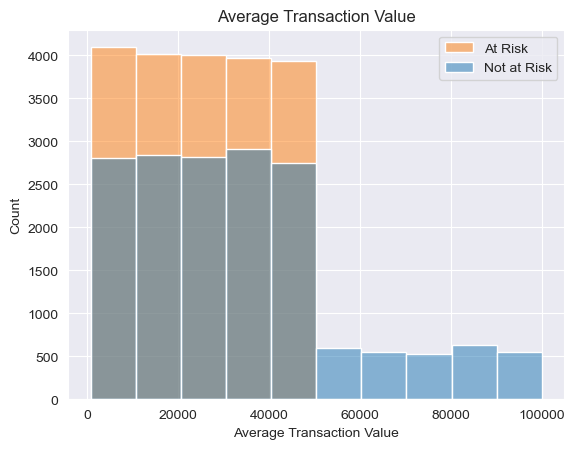

In [6]:
sns.histplot(data = scores, x = "avg_transaction_value", hue="churn_risk_score", bins = 10)
plt.legend(loc='upper right', labels=['At Risk', 'Not at Risk'])
plt.title("Average Transaction Value")
plt.xlabel("Average Transaction Value");

## Data Preparation.

Let's look into our data further and begin our cleaning.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

Looking at the above, we can already see there is missing data for the following columns:
region_category, preferred_offer_types, and points_in_wallet. 

Each of these columns has its own labeling system for missing data. We'll replace these individually. We'll also need to remove rows that contain negative values for predictors that should be positive since there's no way to read these with the information we currently have.

In [8]:
# replacing missing values with np.nan
df["gender"] = df["gender"].replace("Unknown", np.nan)
df["joined_through_referral"] = df["joined_through_referral"].replace("?", np.nan)
df["medium_of_operation"] = df["joined_through_referral"].replace("?", np.nan) 
df["days_since_last_login"] = df["days_since_last_login"].replace(-999, np.nan)
df["complaint_status"] = df["complaint_status"].replace("No Information Available", np.nan)

# removing numerical columns with unreadable negative values
df = df.loc[df["avg_time_spent"] >= 0]
df = df.loc[df["points_in_wallet"] >= 0]

# converting avg_freq_login_days to rounded floats
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].replace('Error', np.nan)
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].astype(float)
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].round(2)
df = df.loc[df["avg_frequency_login_days"] >= 0]

In [9]:
# convert joining_date to age of account
df["joining_date"]= pd.to_datetime(df["joining_date"])
df["age_of_account_in_days"] = (df["joining_date"] - df["joining_date"].min()).astype(str)
df["age_of_account_in_days"] = df["age_of_account_in_days"].str.split('days').str[0]
df["age_of_account_in_days"] = df["age_of_account_in_days"].astype(int)

Now let's look at the data again. We'll see that we dropped about 9000 rows. Not ideal, but without more information about what negative values denote, there's not much we can do.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28271 entries, 0 to 36990
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    28271 non-null  int64         
 1   age                           28271 non-null  int64         
 2   gender                        28230 non-null  object        
 3   security_no                   28271 non-null  object        
 4   region_category               24079 non-null  object        
 5   membership_category           28271 non-null  object        
 6   joining_date                  28271 non-null  datetime64[ns]
 7   joined_through_referral       24108 non-null  object        
 8   referral_id                   28271 non-null  object        
 9   preferred_offer_types         28053 non-null  object        
 10  medium_of_operation           24108 non-null  object        
 11  internet_option             

Let's look at the balance in our target variable "churn_risk_score". Earlier in our histogram, it seemed pretty evenly split but let's make sure. If it's unbalanced, we'll need to consider our sampling methods.

In [11]:
df["churn_risk_score"].value_counts(normalize=True)

1    0.539599
0    0.460401
Name: churn_risk_score, dtype: float64

Looks fairly balanced with about half the rows at risk of churn (class 1) and half not (class 0).

Let's get rid of ID columns and date/time columns. We don't need the latter since we have average use frequency, age of account and days since last login, which are more useful in determining how often the customer uses this site.

In [12]:
df = df.drop(columns = ["Unnamed: 0", "security_no", "referral_id", "last_visit_time", "joining_date"])

In [13]:
df.corr()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,age_of_account_in_days
age,1.000000,-0.002518,-0.003315,-0.004046,-0.001258,0.006333,0.003418,-0.009216
days_since_last_login,-0.002518,1.000000,-0.119600,-0.015025,0.016295,-0.006479,0.015995,-0.009328
avg_time_spent,-0.003315,-0.119600,1.000000,0.020754,-0.000505,0.000699,-0.013060,0.001078
avg_transaction_value,-0.004046,-0.015025,0.020754,1.000000,-0.140501,0.094030,-0.211759,0.002658
avg_frequency_login_days,-0.001258,0.016295,-0.000505,-0.140501,1.000000,-0.057895,0.145655,-0.006401
points_in_wallet,0.006333,-0.006479,0.000699,0.094030,-0.057895,1.000000,-0.315044,0.002564
churn_risk_score,0.003418,0.015995,-0.013060,-0.211759,0.145655,-0.315044,1.000000,0.009801
age_of_account_in_days,-0.009216,-0.009328,0.001078,0.002658,-0.006401,0.002564,0.009801,1.000000


We're not seeing strong correlations between the numerical columns and our target but there's still room to explore further. This table also indicates fairly strong independence between our numeric columns.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28271 entries, 0 to 36990
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           28271 non-null  int64  
 1   gender                        28230 non-null  object 
 2   region_category               24079 non-null  object 
 3   membership_category           28271 non-null  object 
 4   joined_through_referral       24108 non-null  object 
 5   preferred_offer_types         28053 non-null  object 
 6   medium_of_operation           24108 non-null  object 
 7   internet_option               28271 non-null  object 
 8   days_since_last_login         26716 non-null  float64
 9   avg_time_spent                28271 non-null  float64
 10  avg_transaction_value         28271 non-null  float64
 11  avg_frequency_login_days      28271 non-null  float64
 12  points_in_wallet              28271 non-null  float64
 13  u

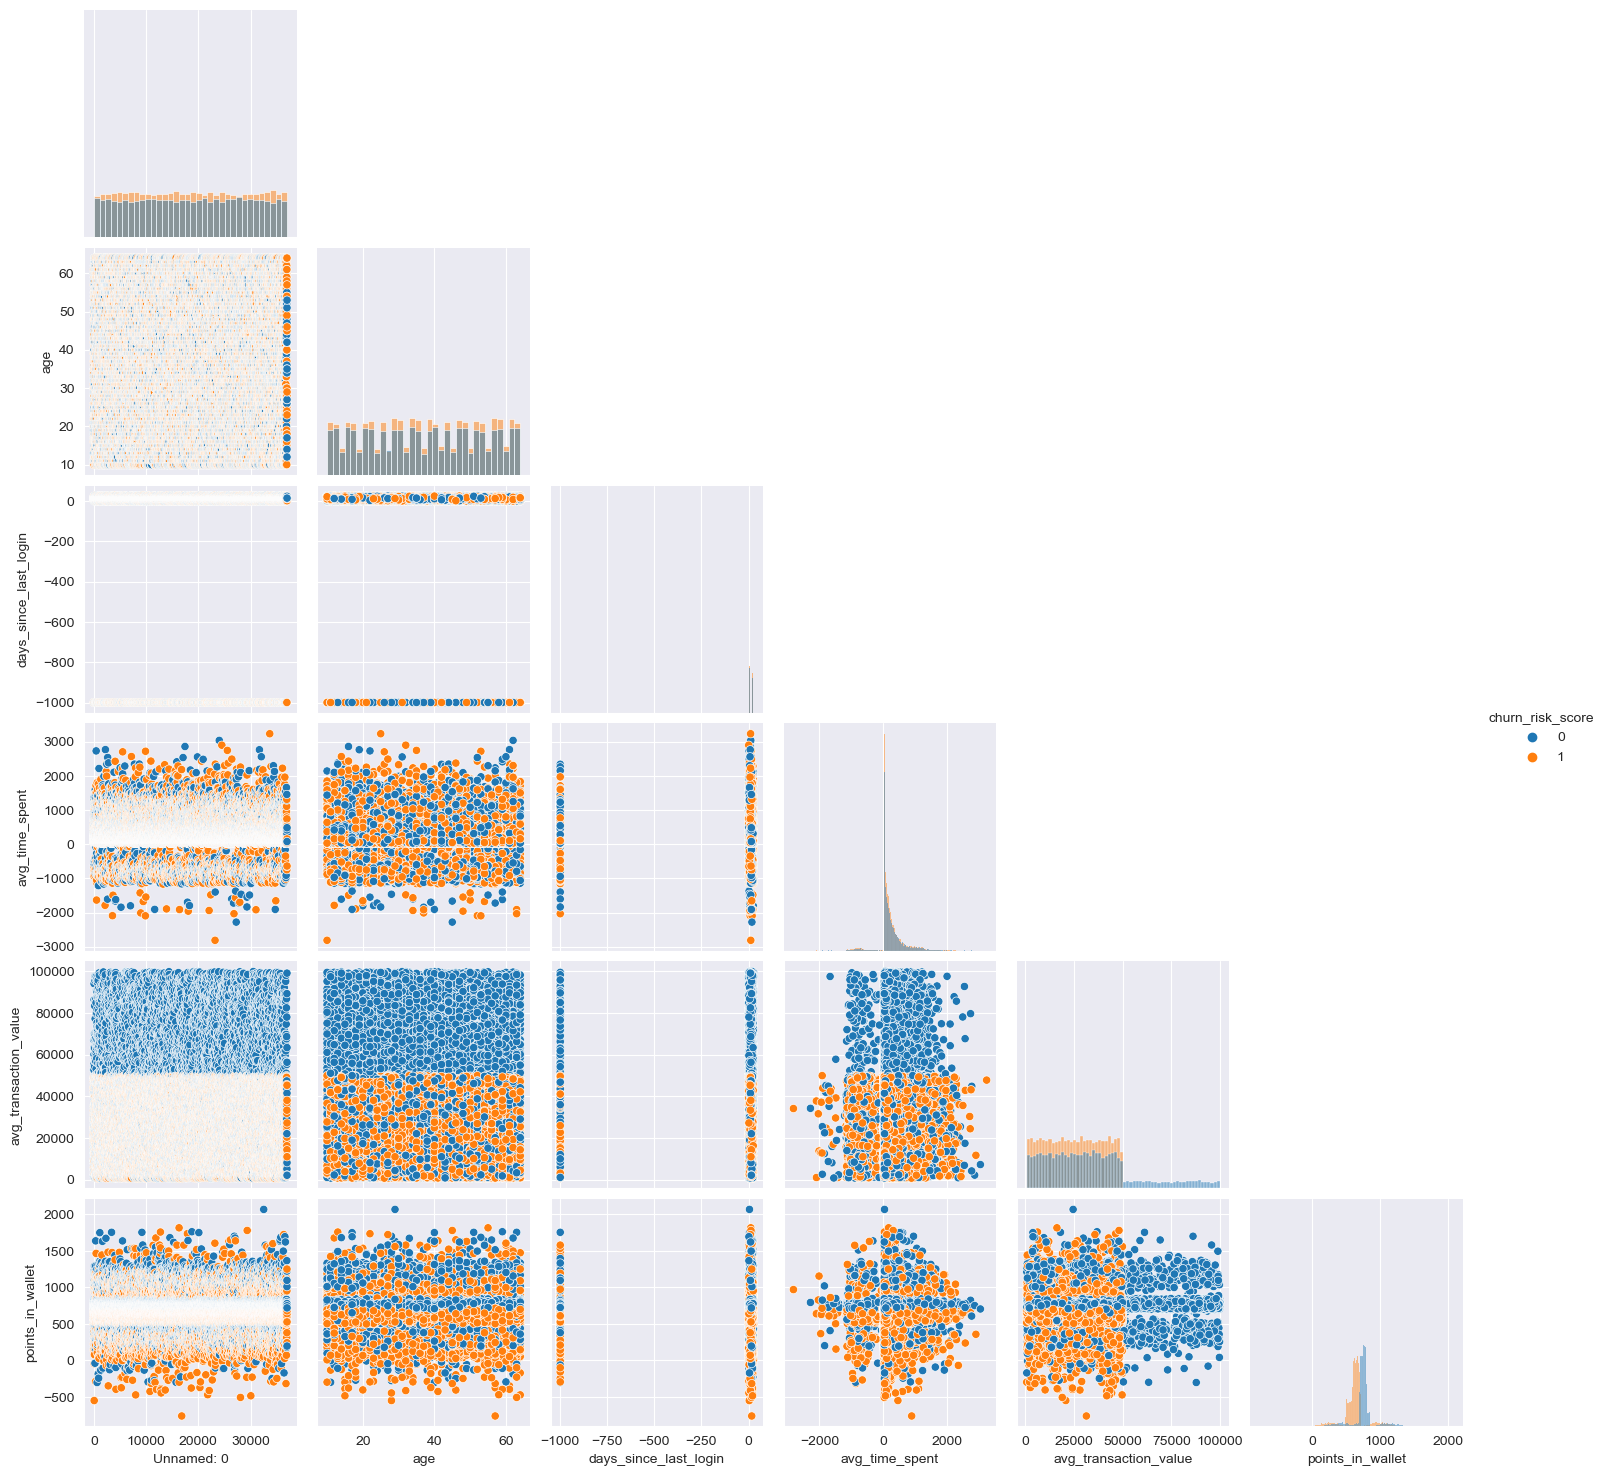

In [7]:
sns.pairplot(df, hue="churn_risk_score", diag_kind="hist", corner=True);

Looks like some columns have outliers. We'll use median to impute missing values in our numeric columns and mode for our categorical ones.

One predictor also indicate a clear division or threshold for class 0 customers (ones who aren't at risk of churn): avg_transaction_value > 50000. Also some values of points_in_wallet seem to almost clearly indicate class 0 or class 1.

This makes sense - users who spend a large amount of money with this site or have points that are beyond the usual, perhaps, freebies the site offers, are less likely to defect. They have shown they use the site consistently. 

## Train-Test Split and Imputation

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28271 entries, 0 to 36990
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           28271 non-null  int64  
 1   gender                        28230 non-null  object 
 2   region_category               24079 non-null  object 
 3   membership_category           28271 non-null  object 
 4   joined_through_referral       24108 non-null  object 
 5   preferred_offer_types         28053 non-null  object 
 6   medium_of_operation           24108 non-null  object 
 7   internet_option               28271 non-null  object 
 8   days_since_last_login         26716 non-null  float64
 9   avg_time_spent                28271 non-null  float64
 10  avg_transaction_value         28271 non-null  float64
 11  avg_frequency_login_days      28271 non-null  float64
 12  points_in_wallet              28271 non-null  float64
 13  u

In [82]:
num_cols = ["age", "days_since_last_login", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", 
           "points_in_wallet", "age_of_account_in_days"]

cat_cols = ["gender", "region_category", "joined_through_referral", "preferred_offer_types",
           "medium_of_operation", "internet_option", "used_special_discount", "offer_application_preference",
           "past_complaint", "complaint_status", "feedback"]
ord_cols = ["membership_category"]

In [83]:
y = df["churn_risk_score"]
X = df.drop(columns="churn_risk_score")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [84]:
ordinal_transformer = Pipeline(steps = [
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordenc', OrdinalEncoder(categories = [membership_order])),
    ('ordnorm', StandardScaler())])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ord_cols),
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## Model 1: Decision Tree

In [41]:
dtc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)
print("train score: %.4f" % dtc.score(X_train, y_train))
print("model score: %.4f" % dtc.score(X_test, y_test))

train score: 1.0000
model score: 0.9157


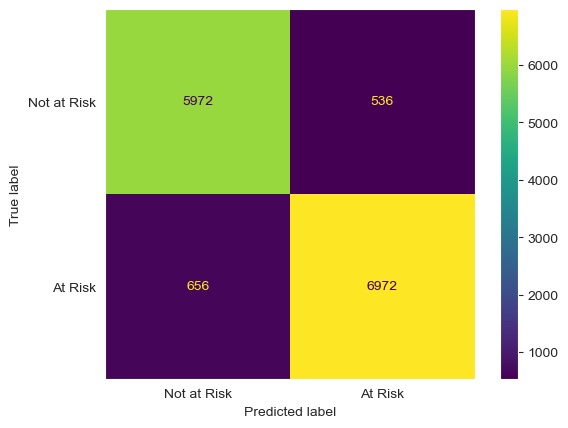

In [44]:
ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [27]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6508
           1       0.93      0.91      0.92      7628

    accuracy                           0.91     14136
   macro avg       0.91      0.91      0.91     14136
weighted avg       0.91      0.91      0.91     14136



If churn_risk_score is between 0 and 1, we can assume that 1 denotes a customer that is at risk of churn while 0 represents one that is not. 

This model is performing well! Though it does seem slightly overfit on the train data. We're seeing an accuracy score of nearly 92% above and solid precision, recall, and f-1. Our model seems to mislabel data in equal measure between false positives and false negatives.

## Model 2: Logistic Regression

In [28]:
lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("train score: %.4f" % lr.score(X_train, y_train))
print("model score: %.4f" % lr.score(X_test, y_test))

train score: 0.8447
model score: 0.8485


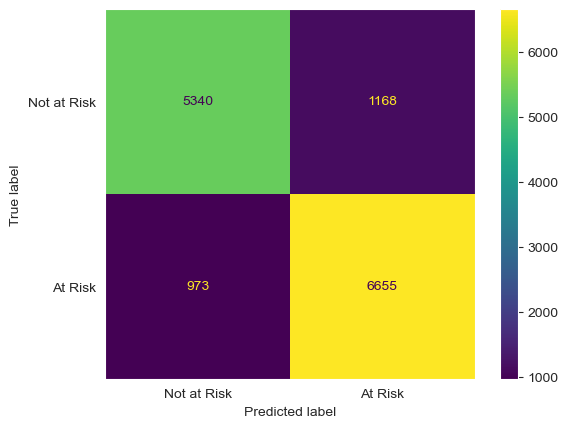

In [45]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [46]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6508
           1       0.85      0.87      0.86      7628

    accuracy                           0.85     14136
   macro avg       0.85      0.85      0.85     14136
weighted avg       0.85      0.85      0.85     14136



This model performs slightly worse than our Decision Tree model, with considerably more false negatives. While precision for class 1 is slightly better here, the other scores are overall worse.

## Model 3: KNN

In [47]:
knn = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print("train score: %.4f" % knn.score(X_train, y_train))
print("model score: %.4f" % knn.score(X_test, y_test))

train score: 0.8870
model score: 0.8346


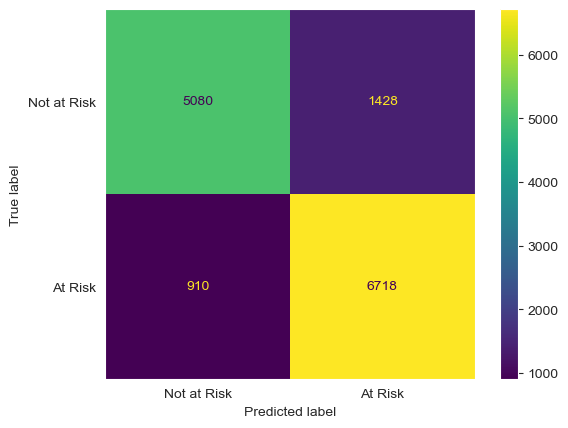

In [48]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [49]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      6508
           1       0.82      0.88      0.85      7628

    accuracy                           0.83     14136
   macro avg       0.84      0.83      0.83     14136
weighted avg       0.84      0.83      0.83     14136



This model performs worse than our first two models, with lower scores almost all around.

So far, our Decision Tree is our best model with a score of nearly 91%. It is slightly skewed towards mislabeling positives but is fairly even overall between its incorrect labeling - nearly 1k of the test set was mislabeled.

Since we're trying to understand customers who are at risk of churn, it matters more to us that we have an accurate model for telling us who is at risk versus who is not. We cannot risk false negatives because if we think a customer is not at risk of churn but they actually are, we won't be able to successfuly re-target them and retain their business. If we re-target customers who are not at risk thinking they are, it is unlikely to cause us to lose their business.

As such, we need a model that minimizes false negatives.

## Model 4: Random Forest

In [50]:
rf = Pipeline(
    steps = [("preprocessor", preprocessor), 
             ('model', RandomForestClassifier(n_estimators = 150, random_state= 42))])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("train score: %.4f" % rf.score(X_train, y_train))
print("model score: %.4f" % rf.score(X_test, y_test))

train score: 1.0000
model score: 0.9388


Again we're seeing overfit. Let's try increasing the number of estimators to see if that improves the model.

In [51]:
rf2 = Pipeline(
    steps = [("preprocessor", preprocessor), 
             ('model', RandomForestClassifier(n_estimators = 400, random_state= 42))])

rf2.fit(X_train, y_train)
pred_rf2 = rf2.predict(X_test)
print("train score: %.4f" % rf2.score(X_train, y_train))
print("model score: %.4f" % rf2.score(X_test, y_test))

train score: 1.0000
model score: 0.9389


We're not seeing major change despite substantially increasing estimators. So we'll go with the first one.

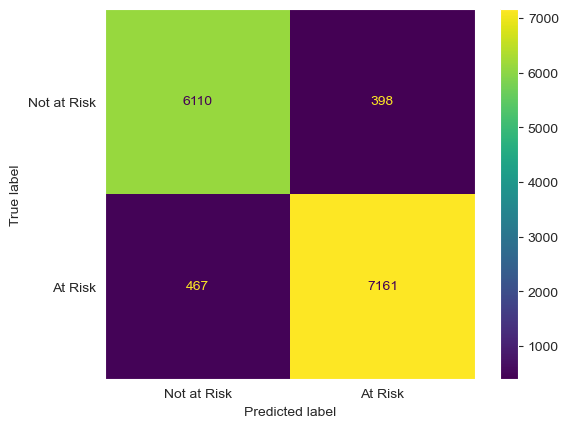

In [52]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [53]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6508
           1       0.95      0.94      0.94      7628

    accuracy                           0.94     14136
   macro avg       0.94      0.94      0.94     14136
weighted avg       0.94      0.94      0.94     14136



This model is doing way better than our other models, with almost 3 points on our Decision Tree model. We're also seeing less false negatives in this model, which is our goal.

## Comparing Best Models So Far

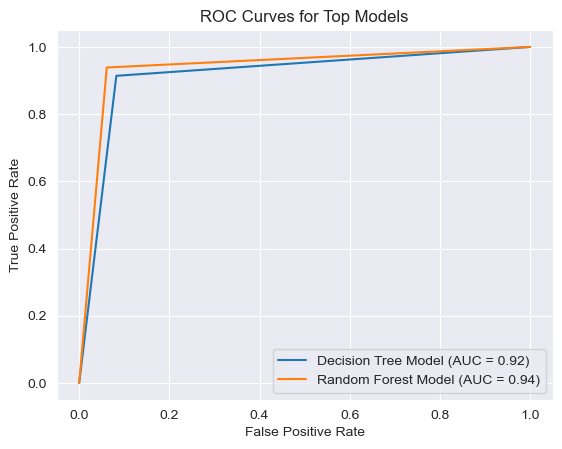

In [54]:
# Compute the false positive rate (FPR) and true positive rate (TPR) for each curve
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_dtc)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, pred_rf)

# Compute the area under the curves (AUC) for each curve
auc1 = metrics.roc_auc_score(y_test, pred_dtc)
auc2 = metrics.roc_auc_score(y_test, pred_rf)

# Plot the ROC curves
plt.plot(fpr1, tpr1, label='Decision Tree Model (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Random Forest Model (AUC = %0.2f)' % auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top Models')
plt.legend(loc='lower right')

# Show the plot
plt.show()

Comparing the ROC curve for our two better models, we see that Random Forest outperforms Decision Tree when it comes to false positives.

## Model 5: Tuned Random Forest

In [55]:
param_grid = {'model__bootstrap': [True, False], 
          'model__max_depth': [4, 8, 12, 16, 20], 
          'model__n_estimators': [50, 100, 150, 200, 250, 300]}

gs_pipe = GridSearchCV(estimator=rf, 
                       param_grid=param_grid)

In [56]:
gs_pipe.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ord',
                                                                         Pipeline(steps=[('ordimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordenc',
                                                                                          OrdinalEncoder(categories=[['No '
                                                                                                                      'Membership',
                                                                                                                      'Basic '
                                                                                                                      'Membership',
                                                                                                                      'Silver '
                                                                                                                      'Membership',
                                                                                                                      'Gold '
                                                                                                                      'Membership',
                                                                                                                      'Premium '
                                                                                                                      'Membership',
                                                                                                                      'Platinum '
                                                                                                                      'Membership']])),
                                                                                         ('ordnorm',
                                                                                          StandardSc...
                                                                          'preferred_offer_types',
                                                                          'medium_of_operation',
                                                                          'internet_option',
                                                                          'used_special_discount',
                                                                          'offer_application_preference',
                                                                          'past_complaint',
                                                                          'complaint_status',
                                                                          'feedback'])])),
                                       ('model',
                                        RandomForestClassifier(n_estimators=150,
                                                               random_state=42))]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [4, 8, 12, 16, 20],
                         'model__n_estimators': [50, 100, 150, 200, 250, 300]})

In [57]:
print("Best model parameters:", gs_pipe.best_params_)
print(f"Model Score: %.4f" % gs_pipe.best_score_)

Best model parameters: {'model__bootstrap': True, 'model__max_depth': 20, 'model__n_estimators': 250}
Model Score: 0.9392


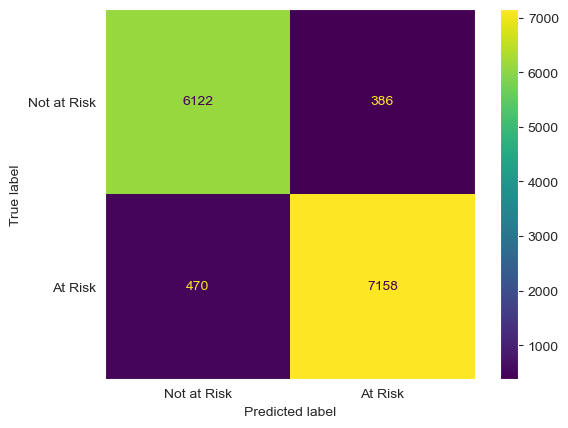

In [58]:
ConfusionMatrixDisplay.from_estimator(gs_pipe.best_estimator_, X_test, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

The tuned Random Forest model performs comparably to the baseline Random Forest model, but it seems the default settings may be better in this case.

## Model 6: XGBoost

In [89]:
X_train_ct = preprocessor.fit_transform(X_train)
boost = XGBClassifier()
boost.fit(X_train_ct, y_train)
print("XGBClassifier model train score: %.4f" % boost.score(X_train_ct, y_train))
X_test_ct = preprocessor.transform(X_test)
pred_boost = boost.predict(X_test_ct)
print("XGBClassifier model validation score: %.4f" % boost.score(X_test_ct, y_test))

XGBClassifier model train score: 0.9901
XGBClassifier model validation score: 0.9426


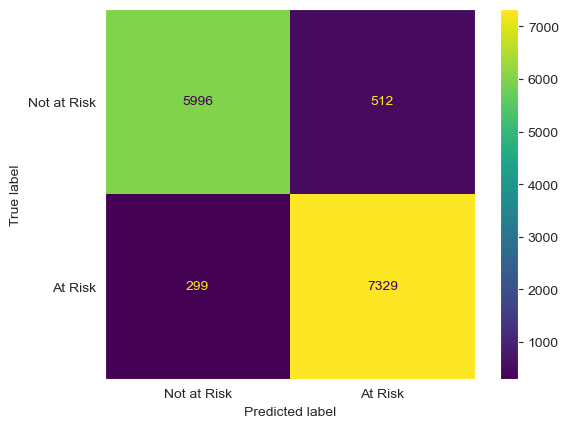

In [90]:
ConfusionMatrixDisplay.from_estimator(boost, X_test_ct, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [91]:
print(classification_report(y_test, pred_boost))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      6508
           1       0.93      0.96      0.95      7628

    accuracy                           0.94     14136
   macro avg       0.94      0.94      0.94     14136
weighted avg       0.94      0.94      0.94     14136



Let's consider all our models now.

In [62]:
print("Decision Tree score: %.4f" % dtc.score(X_test, y_test))
print("Logistic Regression score: %.4f" % lr.score(X_test, y_test))
print("KNN score: %.4f" % knn.score(X_test, y_test))
print("Random Forest score: %.4f" % rf.score(X_test, y_test))
print("Tuned Random Forest score: %.4f" % gs_pipe.best_score_)
print("XGBClassifier score: %.4f" % boost.score(X_test_ct, y_test))

Decision Tree score: 0.9157
Logistic Regression score: 0.8485
KNN score: 0.8346
Random Forest score: 0.9388
Tuned Random Forest score: 0.9392
XGBClassifier score: 0.9426


The XGBoost performs best overall! It also minimizes our false negatives considerably compared to the other models, which is what we're looking for.

## Most Important Features

It's useful to determine what the most important feature in our most successful model is - basically, what should our company look for as a major predictor of churn?

First we need to pull together our transformed column names and our XGBoost model's feature importances.

In [92]:
preprocessor

ColumnTransformer(transformers=[('ord',
                                 Pipeline(steps=[('ordimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordenc',
                                                  OrdinalEncoder(categories=[['No '
                                                                              'Membership',
                                                                              'Basic '
                                                                              'Membership',
                                                                              'Silver '
                                                                              'Membership',
                                                                              'Gold '
                                                                              'Membership',
                                                                              'Premium '
                                                                              'Membership',
                                                                              'Platinum '
                                                                              'Membership']])),
                                                 ('ordnorm',
                                                  StandardScaler())]),
                                 ['membership_category']),
                                ('num',
                                 Pipeline(step...
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'region_category',
                                  'joined_through_referral',
                                  'preferred_offer_types',
                                  'medium_of_operation', 'internet_option',
                                  'used_special_discount',
                                  'offer_application_preference',
                                  'past_complaint', 'complaint_status',
                                  'feedback'])])

In [94]:
preprocessor.transformers_[2][1].steps[1][1].get_feature_names()

array(['x0_F', 'x0_M', 'x1_City', 'x1_Town', 'x1_Village', 'x2_No',
       'x2_Yes', 'x3_Credit/Debit Card Offers',
       'x3_Gift Vouchers/Coupons', 'x3_Without Offers', 'x4_No', 'x4_Yes',
       'x5_Fiber_Optic', 'x5_Mobile_Data', 'x5_Wi-Fi', 'x6_No', 'x6_Yes',
       'x7_No', 'x7_Yes', 'x8_No', 'x8_Yes', 'x9_Not Applicable',
       'x9_Solved', 'x9_Solved in Follow-up', 'x9_Unsolved',
       'x10_No reason specified', 'x10_Poor Customer Service',
       'x10_Poor Product Quality', 'x10_Poor Website',
       'x10_Products always in Stock', 'x10_Quality Customer Care',
       'x10_Reasonable Price', 'x10_Too many ads',
       'x10_User Friendly Website'], dtype=object)

In [111]:
cat_cols

['gender',
 'region_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

In [112]:
columns = ['membership_category', 'age', 'days_since_last_login', 'avg_time_spent',
           'avg_transaction_value', 'avg_frequency_login_days',
           'points_in_wallet', 'age_of_account_in_days',
           'gender_F', 'gender_M', 'region_category_City', 'region_category_Town', 'region_category_Village', 
           'joined_through_referral_No', 'joined_through_referral_Yes', 
           'preferred_offer_types_Credit/Debit Card Offers',
           'preferred_offer_types_Gift Vouchers/Coupons', 'preferred_offer_types_Without Offers', 
           'medium_of_operation_No', 'medium_of_operation_Yes',
           'internet_option_Fiber_Optic', 'internet_option_Mobile_Data', 'internet_option_Wi-Fi', 
           'used_special_discount_No', 'used_special_discount_Yes',
           'offer_application_preference_No', 'offer_application_preference_Yes', 
           'past_complaint_No', 'past_complaint_Yes', 'complaint_status_Not Applicable',
           'complaint_status_Solved', 'complaint_status_Solved in Follow-up', 'complaint_status_Unsolved',
           'feedback_No reason specified', 'feedback_Poor Customer Service',
           'feedback_Poor Product Quality', 'feedback_Poor Website',
           'feedback_Products always in Stock', 'feedback_Quality Customer Care',
           'feedback_Reasonable Price', 'feedback_Too many ads', 'feedback_User Friendly Website']

In [126]:
# zipping our values into a dictionary
zipped = dict(zip(columns, boost.feature_importances_))
zipped = dict(sorted(zipped.items(), key=lambda x: x[1], reverse=True))

# selecting top 10 features
N = 10
zipped10 = dict(itertools.islice(zipped.items(), N))
zipped10

{'membership_category': 0.6101441,
 'points_in_wallet': 0.085614115,
 'feedback_Quality Customer Care': 0.022884453,
 'feedback_Reasonable Price': 0.019554617,
 'feedback_User Friendly Website': 0.01780498,
 'feedback_Products always in Stock': 0.016984591,
 'complaint_status_Solved': 0.010341324,
 'region_category_Village': 0.010329447,
 'avg_transaction_value': 0.010143276,
 'feedback_Poor Product Quality': 0.010017756}

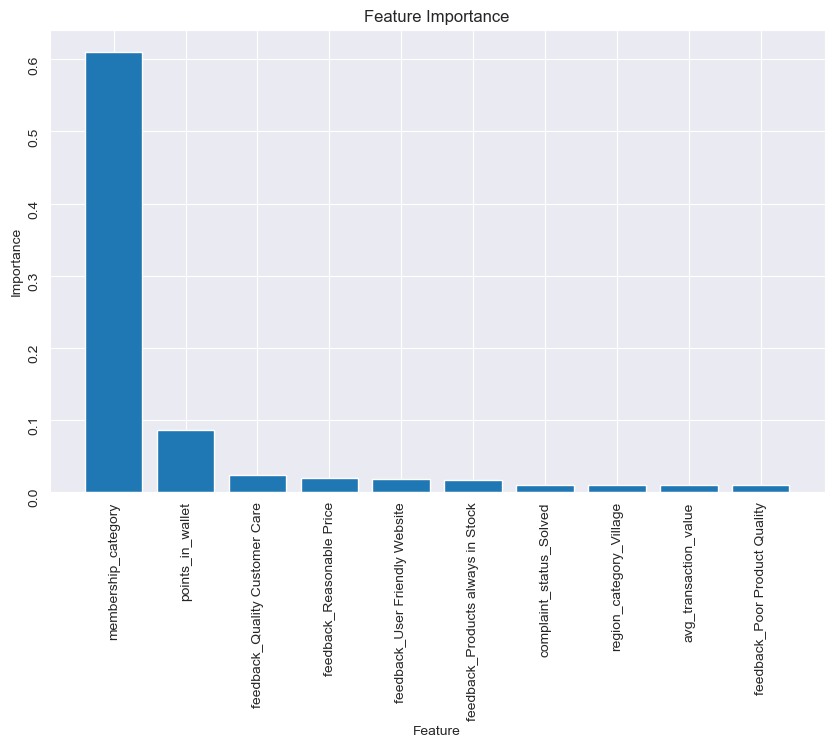

In [127]:
# making the features graph
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(range(len(zipped10)), list(zipped10.values()), tick_label=list(zipped10.keys()))
ax.set_title('Feature Importance')
ax.set_xlabel('Feature')
ax.tick_params(labelrotation=90)
ax.set_ylabel('Importance')
plt.show()

As we guessed at the top, membership_category matters the most out of all our features, followed by another one of our guesses points_in_wallet and giving feedback on customer care quality.

## Removing Membership Category

In [64]:
# transformer pipeline
num_cols = ["age", "days_since_last_login", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", 
           "points_in_wallet", "age_of_account_in_days"]

cat_cols = ["gender", "region_category", "joined_through_referral", "preferred_offer_types",
           "medium_of_operation", "internet_option", "used_special_discount", "offer_application_preference",
           "past_complaint", "complaint_status", "feedback"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# train-test split
y = df["churn_risk_score"]
X = df.drop(columns=["churn_risk_score", "membership_category"])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [65]:
X_train_ct2 = preprocessor.fit_transform(X_train)
boost2 = XGBClassifier()
boost2.fit(X_train_ct2, y_train)
print("train score: %.4f" % boost2.score(X_train_ct2, y_train))
X_test_ct2 = preprocessor.transform(X_test)
pred_boost2 = boost2.predict(X_test_ct2)
print("validation score: %.4f" % boost2.score(X_test_ct2, y_test))

train score: 0.9743
validation score: 0.8909


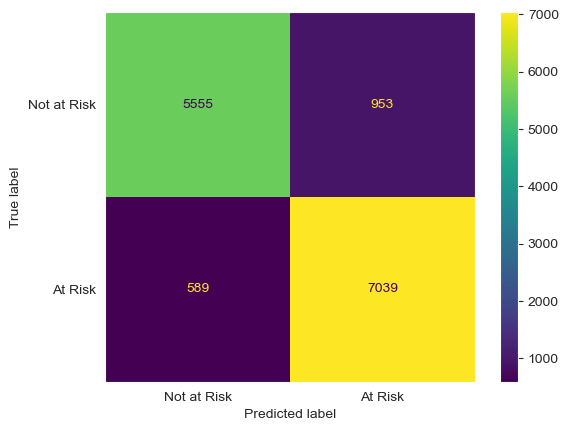

In [66]:
ConfusionMatrixDisplay.from_estimator(boost2, X_test_ct2, y_test, display_labels=["Not at Risk", "At Risk"])
plt.grid(False);

In [67]:
print(classification_report(y_test, pred_boost2))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      6508
           1       0.88      0.92      0.90      7628

    accuracy                           0.89     14136
   macro avg       0.89      0.89      0.89     14136
weighted avg       0.89      0.89      0.89     14136



While removing the membership_category from our XGBoost Classifer model did diminish its accuracy slightly, it doesn't seem like a huge enough difference to focus only on that. It has to work in conjunction with the other elements in this model to successfully predict churn. Also, by removing it, we more false negative mislabeling.

## Digging in Points in Wallet

At the top we saw clear sectioning for points_in_wallet. Using age as baseline y-value since it is generally randomized, we can see this below.

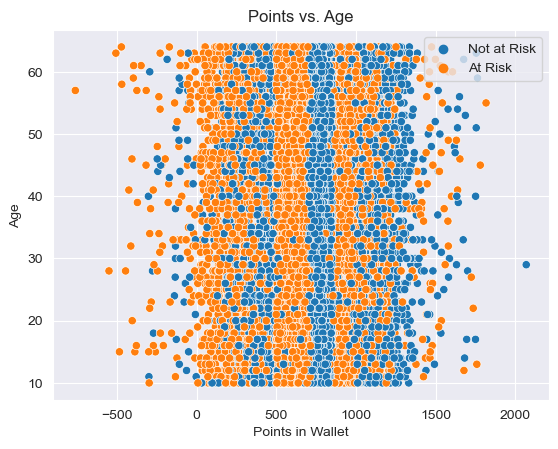

In [245]:
sns.scatterplot(data=scores, x="points_in_wallet", y="age", hue="churn_risk_score")
plt.legend(loc='upper right')
plt.title("Points vs. Age")
plt.xlabel("Points in Wallet")
plt.ylabel("Age");

We should determine which ranges at risk customers are for points_in_wallet.

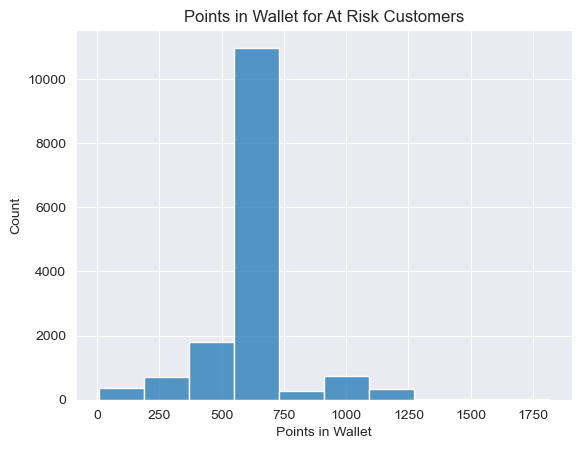

In [246]:
atrisk = df.loc[df["churn_risk_score"] == 1]
atrisk["points_in_wallet"] = atrisk["points_in_wallet"].astype(int)
sns.histplot(data = atrisk, x = "points_in_wallet", bins = 10)
plt.title("Points in Wallet for At Risk Customers")
plt.xlabel("Points in Wallet");

Looks like a good target would be customers who have between 500-750 points.

## Recommendations

We tried half a dozen models, from Decision Tree to Tuned Random Forest, and finally found that our XGBoost Classifier model is our most powerful with nearly 94% successful predictions on the test. We would suggest the company use this model in the future to determine churn risk. There is overfit present in this model and some of the others, which can be solved by improving the data and increasing the amount of data. I had to cut about a quarter of the data out of the analysis, so possibly determining why the values were negative would be a good start. 

We also determined our most important feature in this model: membership_category. This is where our company should look to determine which customers are most at risk of churn, with special focus on customers who have no membership or hold "basic" membership.

They should also do extra outreach to customers who have 500-750 points in their wallets, since this is our second most important feature, and make sure they re-target customers who have voiced opinions on the quality of customer care, our third most important feature.